# Assignment 3b code

## 1. Read datasets

In [55]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_csv('../data/Groceries data train.csv')
df_test = pd.read_csv('../data/Groceries data test.csv')

In [56]:
df_train.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3021,30/01/2015,frankfurter,2015,1,30,4
1,1292,24/10/2015,pork,2015,10,24,5
2,4206,4/04/2014,root vegetables,2014,4,4,4
3,4369,25/08/2015,onions,2015,8,25,1
4,1522,1/07/2014,waffles,2014,7,1,1


In [57]:
df_test.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3481,8/03/2015,candy,2015,3,8,6
1,1254,19/04/2015,white wine,2015,4,19,6
2,2835,28/01/2014,domestic eggs,2014,1,28,1
3,2854,2/08/2015,coffee,2015,8,2,6
4,4637,12/08/2014,bottled water,2014,8,12,1


In [58]:
print(df_train.shape)
print(df_test.shape)

(27000, 7)
(11765, 7)


In [59]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    27000 non-null  int64 
 1   Date             27000 non-null  object
 2   itemDescription  27000 non-null  object
 3   year             27000 non-null  int64 
 4   month            27000 non-null  int64 
 5   day              27000 non-null  int64 
 6   day_of_week      27000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.4+ MB


In [60]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11765 entries, 0 to 11764
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    11765 non-null  int64 
 1   Date             11765 non-null  object
 2   itemDescription  11765 non-null  object
 3   year             11765 non-null  int64 
 4   month            11765 non-null  int64 
 5   day              11765 non-null  int64 
 6   day_of_week      11765 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 643.5+ KB


In [61]:
# number of unique members in each dataset
print(df_train['Member_number'].nunique())  # 3872
print(df_test['Member_number'].nunique())  # 3566

3872
3566


In [62]:
# check intersection of members between train and test
train_members = set(df_train['Member_number'].unique())
test_members = set(df_test['Member_number'].unique())
intersection = train_members.intersection(test_members)
print("number of common members: ", len(intersection))  # 3540
print("Repetition rate: ", len(intersection) / len(train_members))  # 0.9142561983471075

number of common members:  3540
Repetition rate:  0.9142561983471075


In [63]:
# print first 5 members in the intersection
print(list(intersection)[:5])

[1000, 1001, 1002, 1003, 1004]


In [64]:
# group data by member number and create a list of items purchased by each member
train_data = df_train.groupby('Member_number')['itemDescription'].apply(set).apply(list).reset_index()
test_data = df_test.groupby('Member_number')['itemDescription'].apply(set).apply(list).reset_index()

In [65]:
# show first 5 members in the train data
train_data.head()

,Member_number,itemDescription
0,1000,"[yogurt, soda, sausage, pastry, pickled vegeta..."
1,1001,"[soda, white bread, rolls/buns, frankfurter, w..."
2,1002,"[frozen vegetables, whole milk, tropical fruit..."
3,1003,"[dental care, rolls/buns, sausage, detergent, ..."
4,1004,"[shopping bags, cling film/bags, whole milk, r..."


In [66]:
# show first 5 members in the test data
test_data.head()

,Member_number,itemDescription
0,1000,"[salty snack, semi-finished bread, hygiene art..."
1,1001,[frankfurter]
2,1002,"[other vegetables, specialty chocolate]"
3,1003,"[rolls/buns, frozen meals]"
4,1004,"[rolls/buns, tropical fruit, other vegetables,..."


## 2. Exploratory analysis

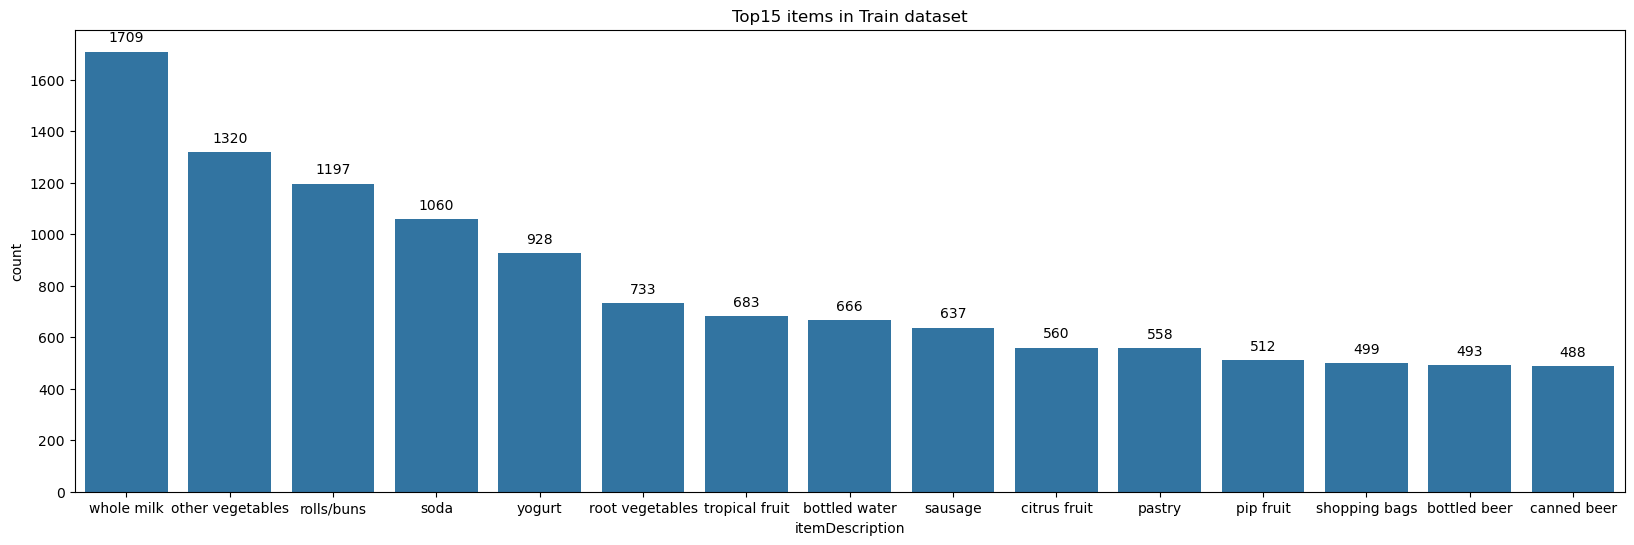

In [67]:
# count the number of items purchased by all members in the df_train
# show the result in a graph in descending order
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))
plt.title("Top15 items in Train dataset")
ax = sns.countplot(x='itemDescription', data=df_train, order=df_train['itemDescription'].value_counts().index[:15])

# Annotate count number on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

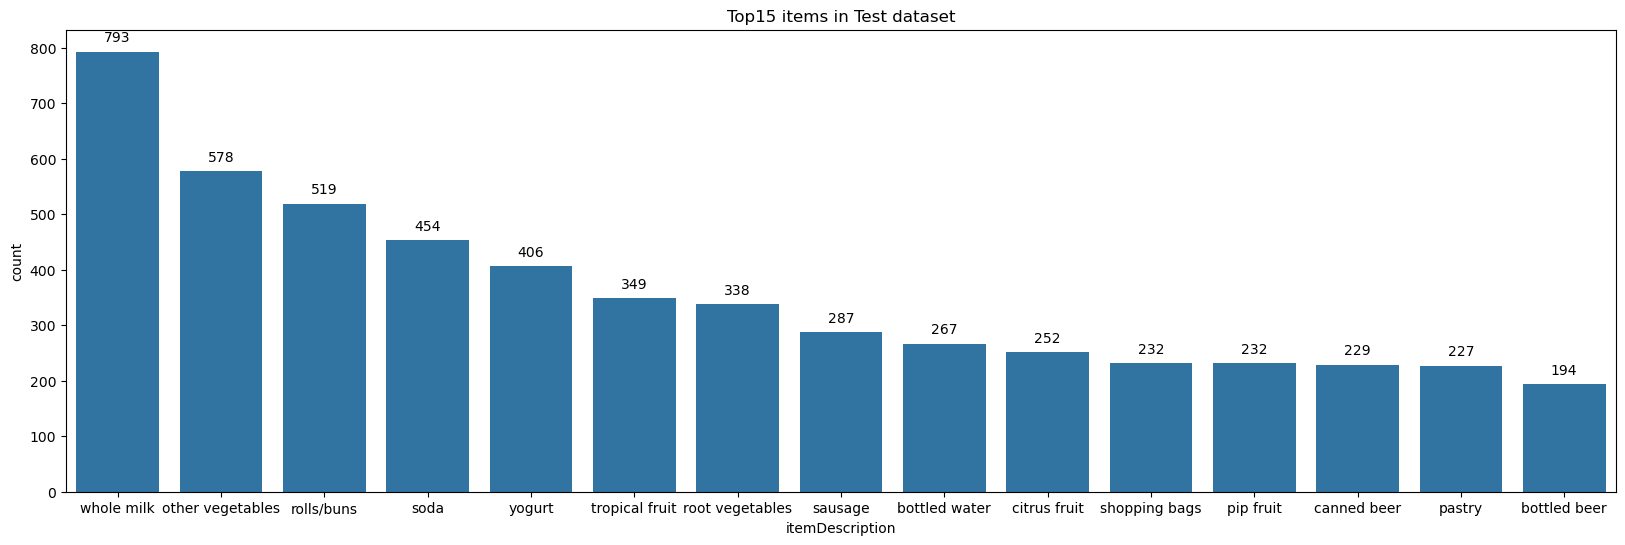

In [68]:
# count the number of items purchased by all members in the df_test
# show the result in a graph in descending order

plt.figure(figsize=(20, 6))
plt.title("Top15 items in Test dataset")
ax = sns.countplot(x='itemDescription', data=df_test, order=df_test['itemDescription'].value_counts().index[:15])

# Annotate count number on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

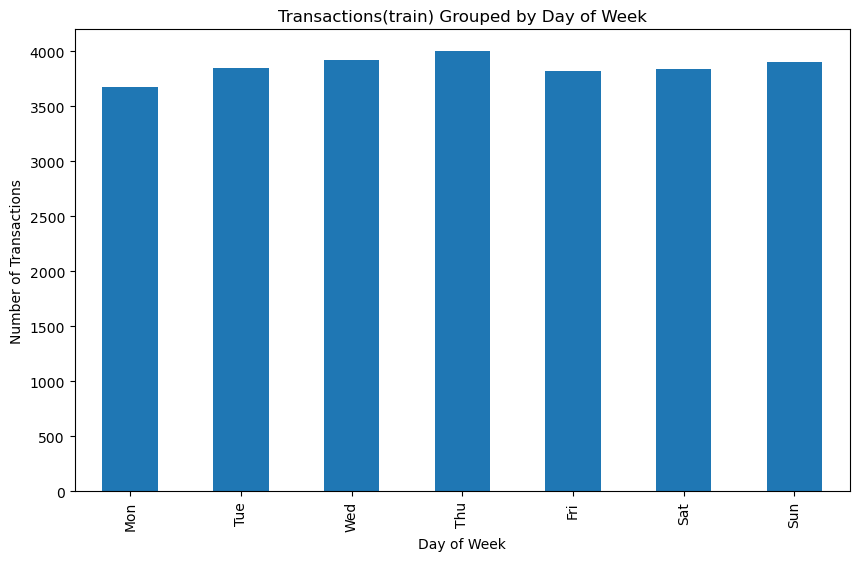

In [69]:
# Group the transactions by day of the week and count the number of transactions
transactions_by_day = df_train.groupby('day_of_week').size()

# Plot the number of transactions by day of the week
plt.figure(figsize=(10, 6))
transactions_by_day.plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Number of Transactions')
plt.title('Transactions(train) Grouped by Day of Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

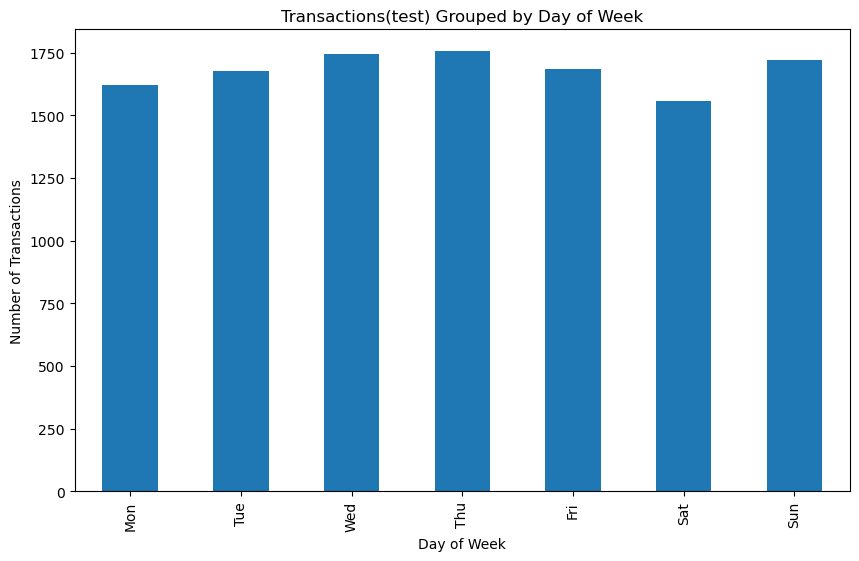

In [70]:
# Group the transactions by day of the week and count the number of transactions
transactions_by_day = df_test.groupby('day_of_week').size()

# Plot the number of transactions by day of the week
plt.figure(figsize=(10, 6))
transactions_by_day.plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Number of Transactions')
plt.title('Transactions(test) Grouped by Day of Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

Text(0.5, 1.0, 'Number of Items Purchased by Members in Train Data')

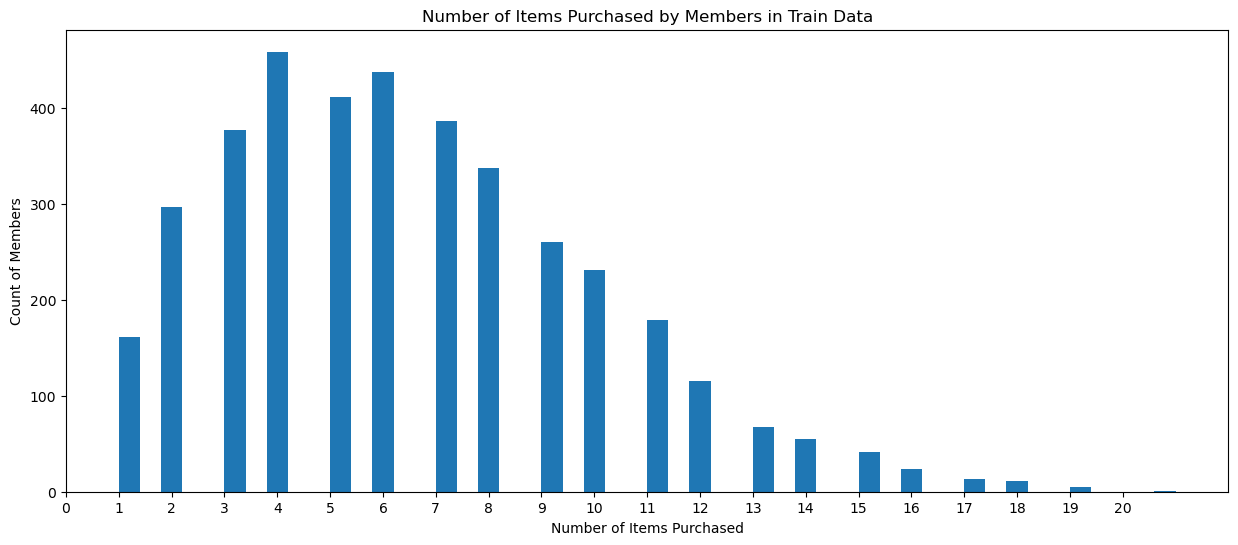

In [71]:
# show number of items purchased by all members in the train data
# x-axis: number of items purchased, y-axis: number of members
plt.figure(figsize=(15, 6))
plt.hist(train_data['itemDescription'].apply(len), bins=50)
plt.xticks(range(0, max(train_data['itemDescription'].apply(len)), 1))
plt.xlabel('Number of Items Purchased')
plt.ylabel('Count of Members')
plt.title('Number of Items Purchased by Members in Train Data')

Text(0.5, 1.0, 'Number of Items Purchased by Members in Test Data')

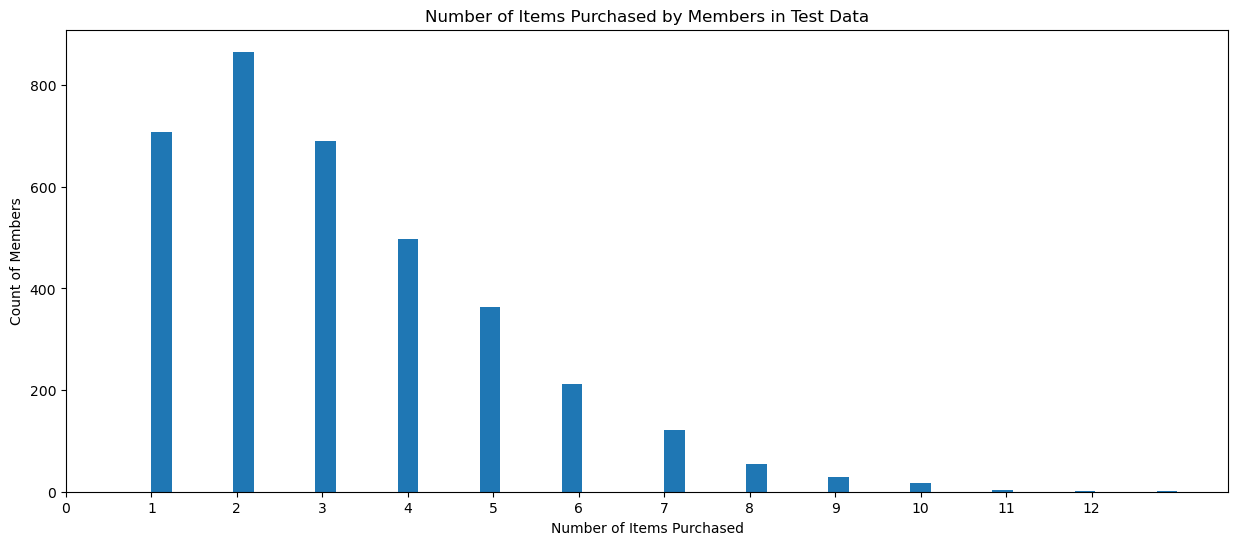

In [72]:
# show number of items purchased by all members in the test data
# x-axis: number of items purchased, y-axis: number of members
plt.figure(figsize=(15, 6))
plt.hist(test_data['itemDescription'].apply(len), bins=50)
plt.xticks(range(0, max(test_data['itemDescription'].apply(len)), 1))
plt.xlabel('Number of Items Purchased')
plt.ylabel('Count of Members')
plt.title('Number of Items Purchased by Members in Test Data')

## 3. Frequent pattern mining

In [73]:
# pick itemsets that has more than 1 item, sort them

train_data = train_data['itemDescription'].tolist()
train_data = [sorted(list(items)) for items in train_data]
train_data = [items for items in train_data if len(items) > 1]

In [74]:
print(type(train_data))
for i in range(5):
    print(train_data[i])

<class 'list'>
['canned beer', 'misc. beverages', 'pastry', 'pickled vegetables', 'sausage', 'soda', 'yogurt']
['beef', 'curd', 'frankfurter', 'rolls/buns', 'sausage', 'soda', 'whipped/sour cream', 'white bread', 'whole milk']
['butter', 'butter milk', 'frozen vegetables', 'sugar', 'tropical fruit', 'whole milk']
['dental care', 'detergent', 'rolls/buns', 'root vegetables', 'sausage']
['canned beer', 'chocolate', 'cling film/bags', 'dish cleaner', 'frozen fish', 'hygiene articles', 'other vegetables', 'pastry', 'pip fruit', 'red/blush wine', 'rolls/buns', 'shopping bags', 'whole milk']


In [75]:
len(train_data)

3711

In [76]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

te = TransactionEncoder()
te_ary = te.fit(train_data).transform(train_data)
train_df = pd.DataFrame(te_ary, columns=te.columns_)
train_df

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3706,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3707,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3708,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3709,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [77]:
# mine frequent itemsets
freq_items = fpgrowth(train_df, min_support=0.002, use_colnames=True)

rules = association_rules(freq_items, metric="confidence", min_threshold=0.4)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(soda, rolls/buns)",(whole milk),0.072487,0.359472,0.032606,0.449814,1.251320,0.006549,1.164203,0.216540
1,"(soda, rolls/buns, other vegetables)",(whole milk),0.025330,0.359472,0.011318,0.446809,1.242958,0.002212,1.157878,0.200548
2,"(soda, other vegetables)",(whole milk),0.075182,0.359472,0.032875,0.437276,1.216440,0.005849,1.138263,0.192394
3,(yogurt),(whole milk),0.212881,0.359472,0.091081,0.427848,1.190213,0.014556,1.119507,0.203037
4,"(yogurt, soda)",(whole milk),0.058744,0.359472,0.026947,0.458716,1.276082,0.005830,1.183349,0.229854
...,...,...,...,...,...,...,...,...,...,...
5438,"(liquor (appetizer), rolls/buns)",(whole milk),0.003773,0.359472,0.002425,0.642857,1.788338,0.001069,1.793479,0.442491
5439,"(liquor (appetizer), whole milk)",(rolls/buns),0.005389,0.272703,0.002425,0.450000,1.650148,0.000956,1.322359,0.396129
5440,"(liquor (appetizer), soda)",(whole milk),0.004042,0.359472,0.002156,0.533333,1.483658,0.000703,1.372560,0.327313
5441,(potato products),(rolls/buns),0.004581,0.272703,0.002156,0.470588,1.725645,0.000907,1.373784,0.422442


In [78]:
# get range of zhang's metric
print(rules['zhangs_metric'].min())
print(rules['zhangs_metric'].max())
rules.describe()

0.10200759631036356
0.9061738424045491


,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
count,5443.000000,5443.000000,5443.000000,5443.000000,5443.000000,5443.000000,5443.000000,5443.000000
mean,0.007862,0.304376,0.003859,0.523778,1.805398,0.001389,inf,0.408271
std,0.010167,0.061532,0.004304,0.102738,0.594871,0.000843,NaN,0.139085
min,0.002156,0.043654,0.002156,0.400000,1.112744,0.000273,1.067547,0.102008
25%,0.004312,0.272703,0.002425,0.444444,1.457164,0.000951,1.273242,0.318635
50%,0.005659,0.292643,0.002695,0.500000,1.669115,0.001229,1.408529,0.403811
75%,0.008084,0.359472,0.003773,0.571429,1.977881,0.001587,1.650499,0.497052
max,0.292643,0.359472,0.117219,1.000000,10.181070,0.014556,inf,0.906174


In [79]:
def predict_items(purchased_items):
    # create a list to store the predicted items
    predicted_items = []
    
    # iterate over the top rules
    for index, row in rules.iterrows():
        # get the items in the antecedent and consequent of the rule
        antecedent = row["antecedents"]
        consequent = row["consequents"]
        
        # check if all the items in the antecedent are in the purchased items
        if antecedent.issubset(purchased_items):
            # add the items in the consequent to the predicted items
            for item in consequent:
                if item not in purchased_items and item not in predicted_items:
                    predicted_items.append(item)
    
    # return the list of predicted items
    return predicted_items

### Example of using prediction function

In [80]:
# make a prediction for a sample set of purchased items
purchased_items = {'canned beer',
 'misc. beverages',
 'pastry',
 'pickled vegetables',
 'sausage',
 'soda',
 'yogurt'}
predicted_items = predict_items(purchased_items)

# print the predicted items to the console
print(predicted_items)

['whole milk', 'rolls/buns', 'other vegetables', 'pip fruit']


## 4. Collaborative filtering

In [81]:
# number of unique items in the dataset
df_train['itemDescription'].unique().size

167

In [82]:
# count the frequency of each item in the dataset, group by Member_number, itemDescription
purchase_counts = df_train.groupby(['Member_number', 'itemDescription']).size().reset_index(name='Purchase_Count')

# define an empty dataframe to store the results
members = df_train['Member_number'].unique()
items = df_train['itemDescription'].unique()

new_df = pd.DataFrame(index=members, columns=items).fillna(0)

# fill the new DataFrame with purchase counts
for _, row in purchase_counts.iterrows():
    member = row['Member_number']
    item = row['itemDescription']
    count = row['Purchase_Count']
    new_df.at[member, item] = count

new_df = new_df.reset_index().rename(columns={'index': 'Member_number'})
new_df.set_index('Member_number', inplace=True)
new_df = new_df.sort_index()
new_df.head()

,frankfurter,pork,root vegetables,onions,waffles,cereals,yogurt,sausage,rolls/buns,chocolate,...,organic sausage,house keeping products,frozen fruits,bathroom cleaner,skin care,bags,rubbing alcohol,make up remover,preservation products,kitchen utensil
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1003,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


### UV decomposition

In [83]:
import numpy as np

# UV decomposition function
def uv_decomposition(R, k, learning_rate, regularization):
    """
    Performs UV decomposition on the input matrix R, with a target rank of k, using stochastic gradient descent (SGD).
    Returns the decomposed matrices U and V.
    """
    # Initialize U and V with random values
    num_users, num_items = R.shape
    U = np.random.rand(num_users, k)
    V = np.random.rand(k, num_items)

    # Perform stochastic gradient descent to optimize U and V
    for epoch in range(10):
        for i in range(num_users):
            for j in range(num_items):
                if R[i, j] > 0:
                    error = R[i, j] - np.dot(U[i, :], V[:, j])
                    U[i, :] += learning_rate * (error * V[:, j] - regularization * U[i, :])
                    V[:, j] += learning_rate * (error * U[i, :] - regularization * V[:, j])

    # Return the decomposed matrices U and V
    return U, V

# RMSE calculation function
def rmse(R, U, V):
    """
    Calculates the Root Mean Squared Error (RMSE) between the actual ratings R and the predicted ratings U*V.
    """
    predicted_R = np.dot(U, V)
    error = R - predicted_R
    error = error[R > 0]  # Only consider known values
    return np.sqrt(np.mean(error**2))

In [84]:
# Convert the purchase counts DataFrame to a numpy array
R = new_df.to_numpy()
R

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [85]:
best_k = None
best_rmse = float('inf')

# Perform UV decomposition for different values of k
for k in range(1, 8):
    U, V = uv_decomposition(R, k, 0.1, 0.1)
    error = rmse(R, U, V)
    print(f"k: {k}, RMSE: {error}")
    if error < best_rmse:
        best_rmse = error
        best_k = k

print(f"Best k: {best_k}, Best RMSE: {best_rmse}")

k: 1, RMSE: 0.29857228698971844
k: 2, RMSE: 0.2985942504834557
k: 3, RMSE: 0.2980403353152765
k: 4, RMSE: 0.2970133690925532
k: 5, RMSE: 0.2984610756785381
k: 6, RMSE: 0.2999405039240191
k: 7, RMSE: 0.299006594124674
Best k: 4, Best RMSE: 0.2970133690925532


In [86]:
# perform UV decomposition with the best k value on train data
U, V = uv_decomposition(R, best_k, 0.1, 0.1)

# Reconstruct the matrix using the decomposed matrices U and V
new_df_columns = new_df.columns
user_ratings = np.dot(U, V)
user_ratings = pd.DataFrame(user_ratings, columns=new_df_columns, index=new_df.index)
# discard ratings of items that were already purchased
user_ratings = user_ratings.where(R == 0).fillna(0)
user_ratings # ratings or interests of each member in each item

,frankfurter,pork,root vegetables,onions,waffles,cereals,yogurt,sausage,rolls/buns,chocolate,...,organic sausage,house keeping products,frozen fruits,bathroom cleaner,skin care,bags,rubbing alcohol,make up remover,preservation products,kitchen utensil
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0.933592,0.950644,1.107814,0.930374,1.016214,0.930839,0.000000,0.000000,1.132913,0.999403,...,0.952749,0.927447,0.740833,0.977384,0.906493,1.054784,0.808963,1.064441,1.108151,0.866521
1001,0.000000,1.072550,1.163931,1.061553,1.136309,1.061589,1.362324,0.000000,0.000000,1.115763,...,1.089449,1.021722,0.981105,1.061686,1.104599,1.055467,1.025792,1.032523,1.328634,0.821719
1002,0.868492,0.878468,0.977920,0.865459,0.935099,0.866088,1.115088,1.065345,1.048162,0.915455,...,0.891148,0.842505,0.776192,0.880603,0.884651,0.902988,0.786986,0.892043,1.070398,0.731432
1003,0.832322,0.824557,0.000000,0.814940,0.871790,0.812588,1.023205,0.000000,0.000000,0.869446,...,0.820485,0.800165,0.644945,0.834612,0.807485,0.857986,0.836728,0.858372,0.970263,0.628510
1004,0.940030,0.958566,1.050834,0.934717,1.006028,0.948639,1.234017,1.130309,0.000000,0.000000,...,0.968625,0.910274,0.866719,0.935879,0.957415,0.988253,0.810470,1.000215,1.269352,0.819866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.857472,0.873704,0.979008,0.850442,0.918377,0.861942,1.114567,1.057299,0.000000,0.910340,...,0.876009,0.837712,0.737281,0.864990,0.849671,0.932392,0.740060,0.952181,1.127142,0.766116
4997,0.857078,0.859866,0.948313,0.845401,0.905698,0.849840,1.087651,1.037998,1.029011,0.898036,...,0.863564,0.824041,0.735162,0.852999,0.856811,0.880760,0.809305,0.882811,1.076776,0.683709
4998,0.743929,0.757217,0.852130,0.745763,0.810793,0.744941,0.962451,0.925064,0.000000,0.788724,...,0.771249,0.727794,0.672148,0.765131,0.761416,0.788496,0.651057,0.775906,0.907090,0.656446


In [87]:
# print top5 recommended items for each member
a = []
for row in user_ratings.iterrows():
    top5 = row[1].sort_values(ascending=False).head(5)
    top5_columns = top5.index
    b = []
    for i in top5.index:
        b.append((i, top5[i]))
    a.append(b)
member_recommendations = pd.DataFrame(a, columns=["top_1", "top_2", "top_3", "top_4", "top_5"], index=user_ratings.index)
member_recommendations.head()

,top_1,top_2,top_3,top_4,top_5
Member_number,,,,,
1000,"(margarine, 1.294039065641517)","(other vegetables, 1.235208178163714)","(rolls/buns, 1.1329130957372213)","(preservation products, 1.108151297288659)","(root vegetables, 1.1078142989282365)"
1001,"(margarine, 1.4388719354457802)","(yogurt, 1.3623235458571699)","(preservation products, 1.3286344655563156)","(other vegetables, 1.3209690532681102)","(pip fruit, 1.250550944590694)"
1002,"(margarine, 1.1766620466782032)","(yogurt, 1.1150880024326641)","(other vegetables, 1.0957482419076396)","(preservation products, 1.070397646667148)","(sausage, 1.065345345390554)"
1003,"(margarine, 1.1466708743738954)","(other vegetables, 1.070140393910443)","(yogurt, 1.0232049243238022)","(pip fruit, 0.9796191583012548)","(preservation products, 0.9702629050640679)"
1004,"(preservation products, 1.2693520163341097)","(margarine, 1.263829396665217)","(yogurt, 1.2340173310545979)","(sausage, 1.130308686202051)","(soft cheese, 1.1049240381570276)"


## 5. Recommendation methods

In [88]:
#calculate precision rate : if one of top 5 recomendation is in test dataset => count += 1
itemsets = df_test.groupby("Member_number")["itemDescription"].apply(list).reset_index()
# x = set(itemsets.iloc[0, 1])
count = 0
for i in range(itemsets.shape[0]):
  is_in = False
  for j in range(5):
    if member_recommendations.iloc[i, j][0] in set(itemsets.iloc[i, 1]):
      is_in = True
  if is_in:
    count += 1

print("precision rate:")
raw_precision = count/itemsets.shape[0]
print(raw_precision)

precision rate:
0.34380257992148067


In [89]:
# # output recomendation use pattern, use predict_items function
# # df_origin = pd.read_csv('../data/Groceries data train.csv')

# pattern_recommendation = new_df.copy()
# pattern_recommendation.drop(pattern_recommendation.columns, axis=1, inplace=True)

# # itemsets = df_origin.groupby("Member_number")["itemDescription"].apply(list).reset_index()
# item_array = []
# for i in range(itemsets.shape[0]):
#   current_itemset = itemsets.iloc[i, 1]
#   predicted_items = predict_items(current_itemset)
#   item_array.append(predicted_items)
# pattern_recommendation['recommendation_item'] = item_array
# pattern_recommendation.head(5)

### Simple combination

In [90]:
# combine association results and collaborative filtering ratings to recommend
def combine_recommendations(predicted_items, uv_top5):
    """
    if the item is in the top 5 of the UV_top5, then recommend it
    if no items are in the top 5 of the UV_top5, then recommend the top 1
    """
    recommendations = []
    # sort top5 by its ratings
    uv_top5 = dict(sorted(uv_top5.items(), key=lambda x: x[1], reverse=True))
    # check if any of the predicted items are in the top5
    recommendations.append([item for item in uv_top5.keys() if item in predicted_items])
    # if no items are in the top5, recommend the top1 only
    if len(recommendations[0]) == 0:
        recommendations[0].append(list(uv_top5.keys())[0])

    return recommendations

### Use Genetic algorithm

In [100]:
import random

# get initial population for genetic algorithm
def get_initial_chromosome(array_transactions):
    chromosome = [random.choice([0, 1]) for _ in range(array_transactions.shape[0] * array_transactions.shape[1])]
    # iterate over array_transactions and set value=1 items to 0
    for i in range(array_transactions.shape[0]):
        for j in range(array_transactions.shape[1]):
            # if the item is bought, set it to 0, do not recommend it
            if array_transactions[i, j] > 0:
                chromosome[i * array_transactions.shape[1] + j] = 0
    # print(chromosome)
    return chromosome

In [101]:
# define the fitness function, sum the total interest of recommended items of all users
def fitness(recommendations, array_transactions):
    fitness = 0
    for (user_idx, good_idx), interest in recommendations.items():
        # only consider goods that the user has not bought
        if array_transactions[user_idx, good_idx] == 0:
            fitness += interest
    return fitness

In [102]:
print(user_ratings.iloc[0, 0])

0.9335916534412089


In [107]:
# use genetic algorithm to generate recommendations

# define the genetic algorithm
def genetic_algorithm(array_transactions, num_generations, population_size, mutation_rate):
    # initialize the population
    population = []
    top_population = []
    for _ in range(population_size):
        # generate a random chromosome
        chromosome = get_initial_chromosome(array_transactions)
        population.append(chromosome)

    # evolve the population
    for generation in range(num_generations):
        # evaluate the fitness of each chromosome
        fitnesses = []
        for chromosome in population:
            recommendations = {}
            for i, value in enumerate(chromosome):
                user_idx = i // array_transactions.shape[1]
                item_idx = i % array_transactions.shape[1]
                if value == 1 and user_ratings.iloc[user_idx, item_idx] > 0.0:
                    recommendations[(user_idx, item_idx)] = user_ratings.iloc[user_idx, item_idx]
            fitnesses.append(fitness(recommendations, array_transactions))

        # select the top chromosomes
        top_population = [population[i] for i in np.argsort(fitnesses)[-population_size:]]

        # create the next generation
        new_population = []
        for _ in range(population_size):
            # pick the best 2 as parents
            parent1 = top_population[-1]
            parent2 = top_population[-2]
            child = []
            for i in range(len(parent1)):
                if random.random() < mutation_rate:
                    child.append(random.choice([parent1[i], parent2[i]]))
                else:
                    child.append(parent1[i])
            new_population.append(child)
        population = new_population

    return top_population

In [108]:
new_df.head()

,frankfurter,pork,root vegetables,onions,waffles,cereals,yogurt,sausage,rolls/buns,chocolate,...,organic sausage,house keeping products,frozen fruits,bathroom cleaner,skin care,bags,rubbing alcohol,make up remover,preservation products,kitchen utensil
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1003,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [111]:
# take the first 10 members to generate recommendations
new_df = new_df.head(10)
numpy_array = new_df.to_numpy()

In [112]:
top_population = genetic_algorithm(numpy_array, 100, 10, 0.5)

In [113]:

# Get the best recommendation with the highest fitness
best_recommendation = top_population[-1]
# put the recommendation into a DataFrame
recommendations = pd.DataFrame(np.array(best_recommendation).reshape(new_df.shape), columns=new_df.columns, index=new_df.index)
recommendations

,frankfurter,pork,root vegetables,onions,waffles,cereals,yogurt,sausage,rolls/buns,chocolate,...,organic sausage,house keeping products,frozen fruits,bathroom cleaner,skin care,bags,rubbing alcohol,make up remover,preservation products,kitchen utensil
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,1,0
1001,0,0,0,0,1,1,0,0,0,1,...,1,0,1,1,1,0,1,0,0,1
1002,1,0,1,1,1,1,1,1,1,0,...,1,1,1,0,0,0,1,1,1,1
1003,1,0,0,1,0,1,1,0,0,1,...,1,1,1,0,1,0,0,1,1,0
1004,1,0,1,0,1,0,0,0,0,0,...,1,0,1,0,0,1,1,0,0,1
1005,0,1,0,0,0,1,0,1,0,1,...,1,1,1,0,1,0,1,0,0,0
1006,0,0,1,1,1,1,1,0,0,0,...,1,1,0,1,1,0,0,0,0,0
1008,0,0,0,1,1,0,0,1,1,0,...,0,1,1,1,1,0,0,0,1,1
1009,0,0,1,1,0,1,0,0,0,1,...,1,1,0,0,0,0,1,1,1,0


In [120]:
# extract recommended items from recommendations
recommendations_array = []
for index, row in recommendations.iterrows():
    recommended_items = []
    for item in row.index:
        if row[item] == 1:
            recommended_items.append(item)
    print("User: ", index)
    print("Recommended Items: ", recommended_items)
    recommendations_array.append(recommended_items)

User:  1000
Recommended Items:  ['frankfurter', 'pork', 'root vegetables', 'whipped/sour cream', 'butter', 'whole milk', 'sugar', 'specialty cheese', 'fruit/vegetable juice', 'spices', 'coffee', 'cream cheese ', 'red/blush wine', 'dessert', 'long life bakery product', 'domestic eggs', 'abrasive cleaner', 'liquor (appetizer)', 'semi-finished bread', 'newspapers', 'female sanitary products', 'salt', 'sauces', 'oil', 'snack products', 'brown bread', 'hamburger meat', 'liver loaf', 'soups', 'hard cheese', 'canned vegetables', 'citrus fruit', 'salty snack', 'cat food', 'meat', 'candy', 'UHT-milk', 'chewing gum', 'chicken', 'soft cheese', 'bottled water', 'mustard', 'seasonal products', 'dental care', 'grapes', 'fish', 'finished products', 'dishes', 'frozen fish', 'frozen dessert', 'flower (seeds)', 'male cosmetics', 'nuts/prunes', 'rice', 'turkey', 'ice cream', 'sliced cheese', 'baking powder', 'kitchen towels', 'specialty vegetables', 'flour', 'pudding powder', 'sparkling wine', 'photo/fil

## 6. Results

Genetic algorithm can be used to generate recommendations for users based on their interests. The genetic algorithm can be used to evolve a population of chromosomes that represent the recommendations for each user. The fitness of each chromosome is evaluated based on the total interest of the recommended items for all users. The genetic algorithm can be used to generate recommendations that maximize the total interest of the recommended items for all users. The genetic algorithm can be used to generate recommendations that are diverse and cover a wide range of items. The genetic algorithm can be used to generate recommendations that are novel and introduce users to new items.  
The genetic algorithm can be used to generate recommendations that are fair and unbiased towards all users.  
The genetic algorithm can be used to generate recommendations that are serendipitous and can surprise users with unexpected items. The genetic algorithm can be used to generate recommendations that are diverse and can expose users to a variety of items. The genetic algorithm can be used to generate recommendations that are novel and can introduce users to new and interesting items.